Here I try to recreate all the function in the R files (estimator, filter and simulator) in the Python language to check if I have really understood the topic.

In [174]:
import math
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import scipy.stats as stats


In [179]:
def martingale_diff(y, mu_t, varsigma, nu):
    u_t = ((1 / (1 + (y - mu_t)**2)/(nu*varsigma)) * (y - mu_t))

    return u_t

In [180]:
def uSTD_uDCS_t(y, mu_t, varsigma, nu, log):
    ulpdf = (lgamma((nu + 1) / 2) - lgamma(nu / 2) - (1/2) * log(varsigma) -
              (1/2)  * log(pi * nu) - ((nu + 1) / 2) * log(1 + (y - mu_t)^2 / (nu*varsigma) ))
    if (log != TRUE):
        ulpdf = math.exp(ulpdf)
        
    return ulpdf

In [181]:
def uDCS_t_model_filter (y, theta):
    
    T = len(y)

    dloglik = np.zeros(n)
    loglik = float()

    omega = theta[1]
    phi = theta[2]
    k = theta[3]
    varsigma = theta[4]
    nu = theta[5]

    mu_t = np.full(T+1, np.nan)
    u_t = np.full(T, np.nan)

    mu_t[0] = omega

    dloglik[0] = uSTD_uDCS_t(y[0], mu_t[0], varsigma=varsigma, nu=nu, log=TRUE)

    for t in range (1, T +1):
        u_t[t-1] = martingale_diff(y[t-1], mu[t-1], varsigma, nu)
        mu_t[t] = omega + phi * (mu_t[t-1]- omega) + k * u_t[t-1]

        if t < T+1:
            dloglik[t] = uSTD_uDCS_t(y[t], mu_t=mu_t[t], varsigma= varsigma, nu = nu, log= TRUE)
            loglik = loglik + dloglik[t]

    mu_t = np.array([np.nan] * (T+1))
    u_t = np.array([np.nan] * T)

    out = {'Dynamic Location': mu_t,
           'Innovation': u_t,
           'Log_Densities_i': dloglik,
           'Log_Likelihood' : loglik
    }

    return out
    


In [182]:
def uSTDT_rnd (n, mu, varsigma, nu):
    z = stats.t.rvs(df=nu, size=n)
    y = np.empty(n)
    for i in range(0, n):
        y[i] = mu + z[i]* np.sqrt(varsigma)
    
    return y
    

In [183]:
def uDCS_t_model_simulator (T, omega, phi, k, varsigma, nu):

    y = np.full(T, np.nan)
    mu_t = np.full(T, np.nan)
    u_t = np.full(T, np.nan)

    mu_t[0] = omega

    y[0] = uSTDT_rnd(1, mu_t[0], varsigma, nu)
    print(y[0])

    for t in range(1, T):

        u_t[t-1] = martingale_diff(y[t-1], mu_t[t-1], varsigma, nu)
        mu_t[t] = omega + phi * (mu_t[t-1] - omega) + k * u_t[t-1]
        y[t] = uSTDT_rnd(1, mu_t[t], varsigma, nu)

    out = {
        'y_t_gen': np.array(y),
        'Dynamic_Location': np.array(mu_t),
        'Innovation_u_t': np.array(u_t)
    }

    return out

In [184]:
def uDCS_t_model_estimator (data, param):

    T = len(data)

    omega = param[1]
    phi = param[2]
    k = param[3]

    varsigma = param[4]
    nu = param[5]

    theta_st = [omega, phi, k, varsigma, nu]

    lower =[-Inf, -0.999, -2, 1e-05, 2.099]
    upper =[ Inf,  0.999,  2, Inf, 300]

    optimizer = minimize(fun=interprete_uDCS_t_model, x0=theta_st, args=(dati,), method='L-BFGS-B', bounds=list(zip(lower, upper)), options={'disp': True})

# Save the optimized parameters Dynamic Location
    omega_opt = optimizer.x[0]
    phi_opt = optimizer.x[1]
    k_opt = optimizer.x[2]

    varsigma_opt = optimizer.x[3]
    nu_opt = optimizer.x[4]

# Create a vector with ALL the optimized parameters
    theta_opt = np.array([omega_opt, phi_opt, k_opt, varsigma_opt, nu_opt])

# Create a dictionary with ALL the optimized parameters
    theta_dict = {
        'omega': omega_opt,
        'phi': phi_opt,
        'k': k_opt,
        'varsigma': varsigma_opt,
        'nu': nu_opt
    }   

    out = {
    'theta_list': theta_dict,
    'theta': theta_opt,
    'optimizer': optimizer
    }

    return out

-0.27357336883088745


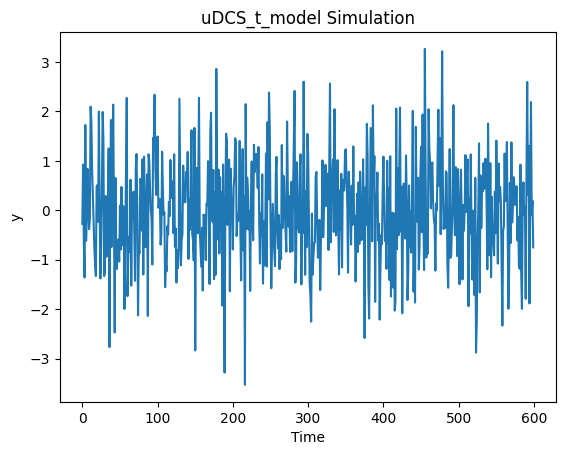

In [185]:
T = 600
omega = 0
phi = 0.8
k = 0.8
varsigma = 1
nu = 40

theta = [omega, phi, k ,varsigma, nu]

simu = uDCS_t_model_simulator(T, omega, phi, k ,varsigma, nu)

y = simu['y_t_gen']


# Plot the time series
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('uDCS_t_model Simulation')
plt.show()


Plot ut against yt for ν = 3, 10, 200. Comment the results in terms of response of the score to extreme observations

-1.0716438979861542


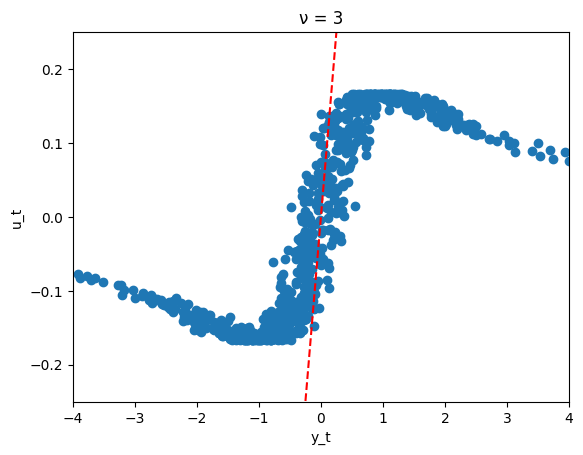

0.8534771675653722


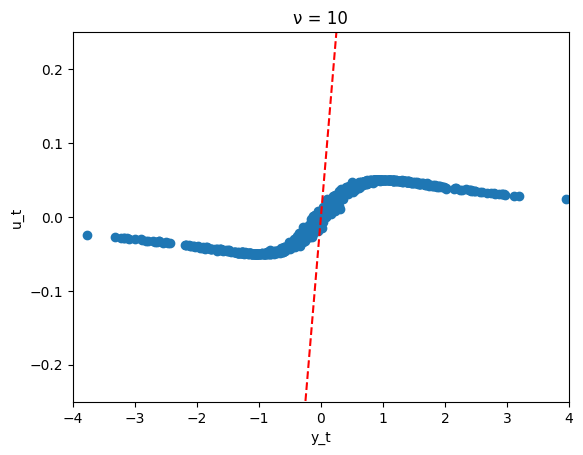

0.7953852872568823


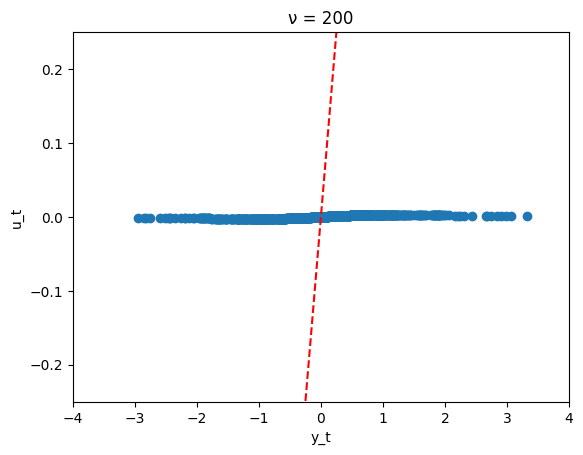

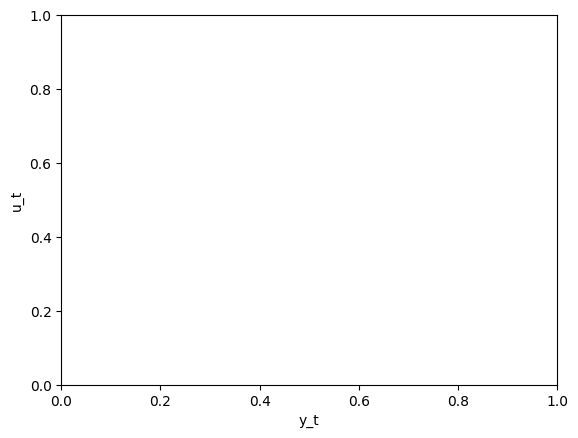

interactive(children=(IntSlider(value=3, description='ν:', max=200, min=3, step=10), Output()), _dom_classes=(…

In [203]:
T = 800
omega = 0
phi = 0.8
k = 1
varsigma = 1

nu_values = [3, 10, 200]

for nu in nu_values:
    simu = uDCS_t_model_simulator(T, omega, phi, k, varsigma, nu)
    y = simu['y_t_gen']
    u = simu['Innovation_u_t']
    
    plt.scatter(y, u)
    plt.xlabel('y_t')
    plt.ylabel('u_t')
    plt.title('ν = ' + str(nu))
    plt.xlim([-4,4])
    plt.ylim([-.25,.25])
    min_value = min(np.min(y), np.min(u))
    max_value = max(np.max(y), np.max(u))
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')
    plt.show()

fig, ax = plt.subplots()
plt.xlabel('y_t')
plt.ylabel('u_t')

def update_plot(nu):
    ax.clear()
    simu = uDCS_t_model_simulator(T, omega, phi, k, varsigma, nu)
    y = simu['y_t_gen']
    u = simu['Innovation_u_t']
    
    ax.scatter(y, u)
    ax.set_title('ν = ' + str(nu))
    plt.xlabel('y_t')
    plt.ylabel('u_t')
    display(fig)

slider = widgets.IntSlider(min=3, max=200, step=10, description='ν:', value=3)
widgets.interactive(update_plot, nu=slider)